<a href="https://colab.research.google.com/github/smallcats/TopicalLanguageModels/blob/master/Neural_TLM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 1.x

import numpy as np
import pandas as pd
import warnings

import nltk
from nltk.corpus import stopwords
import re

from keras.layers import Input, Embedding, LSTM, Dense, Flatten, Lambda, Concatenate, Reshape, Dot
from keras.models import Model
import keras.backend as K
from keras.callbacks import Callback

from gensim.models import Word2Vec

from matplotlib import pyplot as plt

Using TensorFlow backend.


In [2]:
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('stopwords')

stopwords = stopwords.words('english')

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [4]:
thurs = nltk.corpus.gutenberg.raw('chesterton-thursday.txt')
leaves = nltk.corpus.gutenberg.raw('whitman-leaves.txt')
len(thurs), len(leaves)

(320525, 711215)

In [5]:
thurs = thurs.split('\n\n')
leaves = leaves.split('\n\n')
len(thurs), len(leaves)

(1304, 2867)

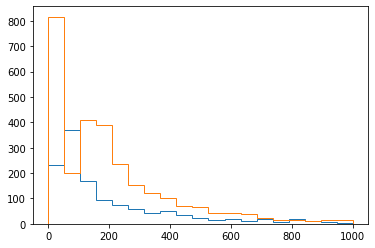

In [6]:
plt.hist([len(d) for d in thurs], bins=np.linspace(0,1000,20), histtype='step')
plt.hist([len(d) for d in leaves], bins=np.linspace(0,1000,20), histtype='step')
plt.show()

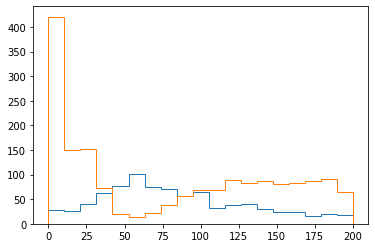

In [7]:
plt.hist([len(d) for d in thurs if len(d)<200], bins=np.linspace(0,200,20), histtype='step')
plt.hist([len(d) for d in leaves if len(d)<200], bins=np.linspace(0,200,20), histtype='step')
plt.show()

In [8]:
len([d for d in thurs if len(d)>50]), len([d for d in leaves if len(d)>50])

(1084, 2054)

In [0]:
texts = [d for d in thurs if len(d)>50]+[d for d in leaves if len(d)>50]

In [0]:
texts = [' '.join(d.split()) for d in texts]
texts = [d for d in texts if len(d)>50]

In [11]:
texts[10]

"The man with the meek blue eyes and the pale, pointed beard endured these thunders with a certain submissive solemnity. The third party of the group, Gregory's sister Rosamond, who had her brother's braids of red hair, but a kindlier face underneath them, laughed with such mixture of admiration and disapproval as she gave commonly to the family oracle."

In [0]:
sents = '\n'.join(texts)
sents = nltk.tokenize.sent_tokenize(sents)

In [0]:
def doc2words(doc):
  words = nltk.tokenize.word_tokenize(doc)
  words = [w.lower() for w in words if w.isalpha()]
  words = [w for w in words if (len(w)>1) and (w not in stopwords)]
  return words

In [0]:
sents = [doc2words(s) for s in sents]
sents = [s for s in sents if len(s)>0]

In [0]:
emb = Word2Vec(sents)

In [16]:
emb.wv.similar_by_word('door')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('states', 0.9998502731323242),
 ('close', 0.999845027923584),
 ('sea', 0.9998437762260437),
 ('air', 0.9998372197151184),
 ('along', 0.9998346567153931),
 ('yet', 0.9998326301574707),
 ('faces', 0.9998325705528259),
 ('years', 0.9998302459716797),
 ('street', 0.9998301863670349),
 ('alone', 0.9998270273208618)]

In [0]:
we = {w:emb.wv.get_vector(w) for w in emb.wv.vocab}
vec_size = emb.vector_size

In [0]:
def multiples(it, n):
  for k in range(len(it)-n+1):
    yield it[k:k+n]

class TLMDataGen:
  def __init__(self, documents, word_embedding, doc2words, lm_length, token2idx, vector_size,
               valid_num=None, valid_frac=None, batch_size=20, valid_batch_size=100):
    if valid_num is None and valid_frac is None:
      if len(documents) < 1000:
        valid_num = int(0.1*len(documents))
      else:
        valid_num = 100
    elif valid_num is None:
      valid_num = int(valid_frac*len(documents))

    perm = np.random.permutation(len(documents))
    self.train_idxs = perm[:valid_num]
    self.valid_idxs = perm[valid_num:]

    self.documents = documents
    self.batch_size = batch_size
    self.valid_batch_size = valid_batch_size
    self.word_embedding = word_embedding
    self.doc2words = doc2words
    self.lm_length = lm_length
    self.token2idx = token2idx
    self.vector_size = vector_size

  def get_train_batch(self):
    doc_idxs = np.random.choice(self.train_idxs, size=self.batch_size)
    docs = [self.documents[k] for k in doc_idxs]
    finish_idxs = [np.random.randint(0, len(d)+1) for d in docs]
    
    x_topic = [np.array([self.word_embedding[w] for w in self.doc2words(d) if w in self.word_embedding]) for d in docs]
    x_topic = [d if d.shape != (0,) else np.zeros((1, self.vector_size)) for d in x_topic]
    x_topic = [d.mean(axis=0) for d in x_topic]
    x_topic = np.array(x_topic)

    lm_docs = [d[max(i-self.lm_length,0):i] for i, d in zip(finish_idxs, docs)]
    x_lm = np.array([[0]*(self.lm_length - len(d))+[self.token2idx.get(t,2) for t in d] for d in lm_docs])

    y = np.array([self.token2idx.get(d[i],2) if i != len(d) else 1 for i,d in zip(finish_idxs, docs)])
    
    return [x_topic, x_lm], y

  def get_valid_batch(self):
    doc_idxs = np.random.choice(self.valid_idxs, size=self.valid_batch_size)
    docs = [self.documents[k] for k in doc_idxs]
    finish_idxs = [np.random.randint(0, len(d)+1) for d in docs]
    
    x_topic = [np.array([self.word_embedding[w] for w in self.doc2words(d) if w in self.word_embedding]) for d in docs]
    x_topic = [d if d.shape != (0,) else np.zeros((1, self.vector_size)) for d in x_topic]
    x_topic = [d.mean(axis=0) for d in x_topic]
    x_topic = np.array(x_topic)

    lm_docs = [d[max(i-self.lm_length,0):i] for i, d in zip(finish_idxs, docs)]
    x_lm = np.array([[0]*(self.lm_length - len(d))+[self.token2idx.get(t,2) for t in d] for d in lm_docs])

    y = np.array([self.token2idx.get(d[i],2) if i != len(d) else 1 for i,d in zip(finish_idxs, docs)])
    
    return [x_topic, x_lm], y



class TopicalLanguageModel:
  """
  Neural Topical Language Model.

  attributes:
  num_topics :: int : number of topics
  doc2words :: function : takes a document as a string and returns words
  word_embedding :: dict : keys are words, values are vectors
  vector_size :: int : the dimension of embedding vectors
  lm_length :: int : length of tokens taken into account for character-level language models 
  """
  def __init__(self, num_topics, word_embedding, vector_size, doc2words, lm_length=30, tokens='abcdefghijklmnopqrstuvwxyz '):
    self.num_topics = num_topics
    self.doc2words = doc2words
    self.word_embedding = word_embedding
    self.vector_size = vector_size
    self.lm_length = lm_length

    self.tokens = ['<', '>', '*'] + list(tokens)
    token_idx = [(t, k+3) for k,t in enumerate(list(tokens))] # 0 = start, 1 = end, 2 = unknown
    self.token2idx = {t:k for t,k in token_idx}
    self.idx2token = {k:t for t,k in token_idx}

    self.num_tokens = len(tokens)+3

  def fit(self, documents, batch_size=20, epochs=10, verbose=0, examples_per_epoch=5, example_epoch_skip=1, num_validation_samples=5):
    """
    fit(self, documents)

    documents should be a list of sentences, and a sentence a list of words.
    """
    x_topic = Input(shape=(self.vector_size,))
    h_topic = Dense(self.vector_size, activation='relu')(x_topic)
    out_topic = Dense(self.num_topics, activation='softmax')(h_topic)
    self.topic_model = Model(inputs=[x_topic], outputs=out_topic)
    
    self.language_models = []
    for k in range(self.num_topics):
      x_lm = Input(shape=(self.lm_length,), dtype='int32')
      h_lm = Embedding(input_dim=self.num_tokens, output_dim=self.num_tokens//2, input_length=self.lm_length)(x_lm)
      h_lm = LSTM(self.num_tokens)(h_lm)
      out_lm = Dense(self.num_tokens, activation='softmax')(h_lm)
      lm = Model(inputs=[x_lm], outputs=out_lm)
      self.language_models.append(lm)

    train_topic_input = Input(shape=(self.vector_size,))
    train_lm_input = Input(shape=(self.lm_length,), dtype='int32')

    lm_outputs = [Reshape(target_shape=(self.num_tokens, 1))(lm(train_lm_input)) for lm in self.language_models]
    lm_outputs = Concatenate(axis=2)(lm_outputs)
    topic_mix = self.topic_model(train_topic_input)

    out = Dot(axes=(2, 1), name='mixed_out')([lm_outputs, topic_mix])

    self.train_model = Model(inputs=[train_topic_input, train_lm_input], outputs=[out, topic_mix])

    def mix_loss(y_true, y_pred):
      eps = 1e-10
      mean = K.mean(y_pred, axis=0)

      mean_nentropy = K.mean(K.sum(y_pred*K.log(y_pred+eps), axis=1))
      nentropy_mean = K.sum(mean*K.log(mean+eps))
      return nentropy_mean - mean_nentropy
      

    self.train_model.compile('adam', ['sparse_categorical_crossentropy', mix_loss])

    data_generator = TLMDataGen(documents, word_embedding=self.word_embedding, 
                                doc2words=self.doc2words, 
                                lm_length=self.lm_length, 
                                token2idx=self.token2idx,
                                vector_size=self.vector_size,
                                batch_size = batch_size)

    steps_per_epoch = len(documents)//batch_size
    self.logs = {'examples':[], 'val_loss':[], 'topic_fraction':[], 'topic_entropy':[]}
    for epoch in range(epochs+1):

      #examples
      if epoch%example_epoch_skip == 0:
        if verbose>1:
          print('Getting examples')
        for t in range(self.num_topics):
          for k in range(examples_per_epoch):
            self.logs['examples'].append((self.rollout('', topic=t, maxlen=100), t, epoch))

      #validation loss
      if verbose>1:
        print('Running validation loss')
      xs, y = data_generator.get_valid_batch()
      losses = [self.train_model.test_on_batch(xs, [y, np.zeros((y.shape[0], self.num_topics))]) for k in range(num_validation_samples)]
      self.logs['val_loss'].append(losses)

      #topics
      if verbose>1:
        print('Getting topic distributions')
      xs, y = data_generator.get_valid_batch()
      x = xs[0]
      topics = self.topic_model.predict(x)
      entropies = (-topics*np.log(topics)).sum(axis=1)
      mean_entropy = entropies.mean(axis=0)
      std_entropy = entropies.std(axis=0)
      mean_topics = topics.mean(axis=0)
      self.logs['topic_fraction'].append(mean_topics)
      self.logs['topic_entropy'].append((mean_entropy, std_entropy))

      if epoch<epochs:
        #train
        if verbose>1:
          print('Training')
        avg_loss = 0
        for step in range(steps_per_epoch):
          xs, y = data_generator.get_train_batch()
          avg_loss = (step/(step+1))*avg_loss + self.train_model.train_on_batch(xs, [y, np.zeros((y.shape[0], self.num_topics))])[0]/(step+1)
        #print
        if verbose > 0:
          print('Epoch {0} - Avg train loss: {1}'.format(epoch, avg_loss))
      
  def predict(self, init_doc, topic, method='sample'):
    idx_doc = [self.token2idx.get(c,2) for c in init_doc]
    dlen = len(idx_doc)
    if dlen < self.lm_length:
      idx_doc = [0]*(self.lm_length-dlen)+idx_doc
    elif dlen > self.lm_length:
      idx_doc = idx_doc[-self.lm_length:]

    probs = self.language_models[topic].predict(np.array(idx_doc).reshape((1,-1)))[0]

    if method == 'sample':
      return np.random.choice(self.tokens, p=probs)

    elif method == 'max':
      return self.tokens[np.argmax(probs)]

    elif method == 'distribution':
      return probs

    else:
      raise ValueError('Unknown method.')

  def rollout(self, init_doc, topic, method='monte-carlo', maxlen=100):
    pred_method = 'sample' if method=='monte-carlo' else 'max' if method=='greedy' else ''
    
    for k in range(maxlen-len(init_doc)):
      predicted = self.predict(init_doc, topic, pred_method)
      if predicted == '>': break
      init_doc = init_doc + predicted

    return init_doc

  def get_topics(self, doc):
    words = self.doc2words(doc)
    embedding = np.array([self.word_embedding[w] for w in words if w in self.word_embedding]).mean(axis=0)
    return self.topic_model.predict(embedding.reshape((-1,1)))[0]

In [0]:
K.clear_session()
tlm = TopicalLanguageModel(num_topics=2, word_embedding=we, vector_size=vec_size, doc2words=doc2words)

In [22]:
tlm.fit(texts, epochs=2000, verbose=1, example_epoch_skip=100)

Epoch 0 - Avg train loss: 3.0404317623529686
Epoch 1 - Avg train loss: 2.87151160759804
Epoch 2 - Avg train loss: 2.7156327183430027
Epoch 3 - Avg train loss: 2.548680631014019
Epoch 4 - Avg train loss: 2.381610200955316
Epoch 5 - Avg train loss: 2.227548665725268
Epoch 6 - Avg train loss: 2.110619380688057
Epoch 7 - Avg train loss: 2.0816726707495192
Epoch 8 - Avg train loss: 2.027606780712422
Epoch 9 - Avg train loss: 1.9754096475931313
Epoch 10 - Avg train loss: 1.9277089880062988
Epoch 11 - Avg train loss: 1.8423451204330503
Epoch 12 - Avg train loss: 1.8834184469320843
Epoch 13 - Avg train loss: 1.8292569823754135
Epoch 14 - Avg train loss: 1.8454899283555843
Epoch 15 - Avg train loss: 1.783065258692472
Epoch 16 - Avg train loss: 1.7534288347531597
Epoch 17 - Avg train loss: 1.787668879215535
Epoch 18 - Avg train loss: 1.7449808434033995
Epoch 19 - Avg train loss: 1.7529041010599873
Epoch 20 - Avg train loss: 1.7782854460752928
Epoch 21 - Avg train loss: 1.7501870286770371
Epoch 2

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in multiply


Epoch 34 - Avg train loss: 1.6464678851457752
Epoch 35 - Avg train loss: 1.6372249130255152
Epoch 36 - Avg train loss: 1.6390499464976478
Epoch 37 - Avg train loss: 1.642060929001906
Epoch 38 - Avg train loss: 1.6022363018531072
Epoch 39 - Avg train loss: 1.6077212951122193
Epoch 40 - Avg train loss: 1.5985954002692162
Epoch 41 - Avg train loss: 1.6304152141778905
Epoch 42 - Avg train loss: 1.5756326119105029
Epoch 43 - Avg train loss: 1.5709342922155667
Epoch 44 - Avg train loss: 1.5642588413678689
Epoch 45 - Avg train loss: 1.5735483223047022
Epoch 46 - Avg train loss: 1.5422113721187283
Epoch 47 - Avg train loss: 1.5353508029992766
Epoch 48 - Avg train loss: 1.5598929111774158
Epoch 49 - Avg train loss: 1.5081186523804293
Epoch 50 - Avg train loss: 1.5091566668871137
Epoch 51 - Avg train loss: 1.5656938304503767
Epoch 52 - Avg train loss: 1.530874206851691
Epoch 53 - Avg train loss: 1.4675239832737523
Epoch 54 - Avg train loss: 1.5110860230066845
Epoch 55 - Avg train loss: 1.5283417

In [23]:
tlm.logs.keys()

dict_keys(['examples', 'val_loss', 'topic_fraction', 'topic_entropy'])

In [24]:
pd.set_option('display.max_colwidth', -1)
ex = pd.DataFrame(columns=['example', 'topic_num', 'epoch'], data=tlm.logs['examples'])
ex.sample(10).sort_values('epoch')

,example,topic_num,epoch
26,**not soeap milte erous* *or the stotles* tut the goast thel the s iting a dease solves**,1,200
73,*fter* * dreaen* *he korlald *op in and his our clould bead* *mingul* and theres* *hy the deson the,0,700
77,**rees filsed alf thing the mon the mimitiil*s *** *ipl ceirtions of yone ros fall**,1,700
93,*erhile path cantion one rame and hiws me tode *nducencamararincerorou* upon uped enderedong matt of,0,900
129,*nde me *onged *quans wondect them lamingss* custnodes* ave comans warl be vidtas a luotifulsing bou,1,1200
125,*ou the saids* *e alkelt of hes sands* ander *ands of the *ed bandr* he envom*d the whot the *weadd,1,1200
127,**has but of and stoply to ucces us foliins of your loon in brince**,1,1200
138,*re out is filiad priblly* *athant *nengles as lied beart**roquile buptaf of beying thing ath to cha,1,1300
158,* to des facker* bithted thas wolse ponceg the vaivions and inse and plass* and lowech* **tut co * l,1,1500
193,* dat kens rith and to threk bakience toiver botio *or me*s malk *thald *yme out delk the*oft houed,0,1900


In [25]:
len(tlm.logs['val_loss']), len(tlm.logs['val_loss'][0]), len(tlm.logs['val_loss'][0][0])

(2001, 5, 3)

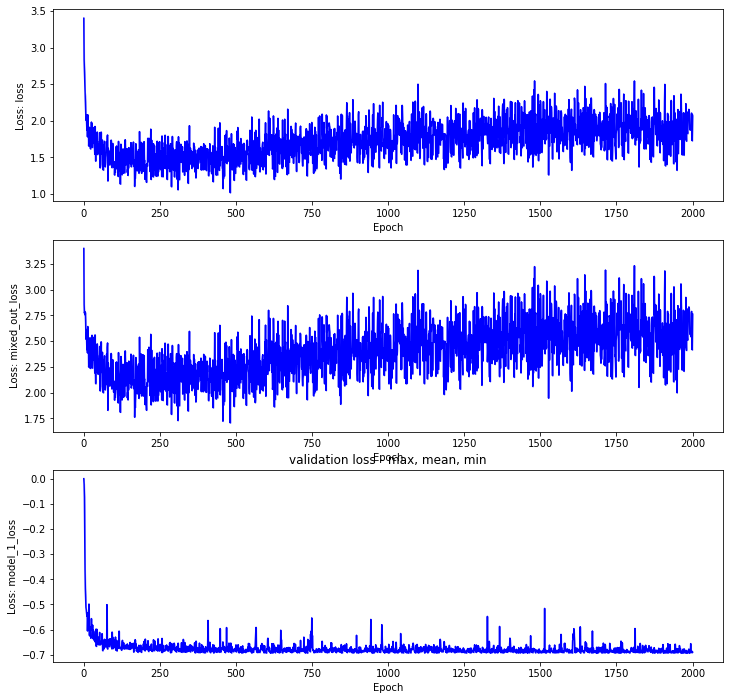

In [26]:
mean_losses = [np.array(v).mean(axis=0) for v in tlm.logs['val_loss']]
max_losses = [np.array(v).max(axis=0) for v in tlm.logs['val_loss']]
min_losses = [np.array(v).min(axis=0) for v in tlm.logs['val_loss']]
epoch = np.arange(len(mean_losses))

fig, axs = plt.subplots(3)
for k in range(3):
  axs[k].plot(epoch, [m[k] for m in mean_losses], color='b')
  axs[k].fill_between(epoch, [m[k] for m in max_losses], [m[k] for m in min_losses], color='b', alpha=0.3)
  axs[k].set_xlabel('Epoch')
  axs[k].set_ylabel('Loss: {}'.format(tlm.train_model.metrics_names[k]))

fig.set_size_inches(12,12)
plt.title('validation loss - max, mean, min')

plt.show()

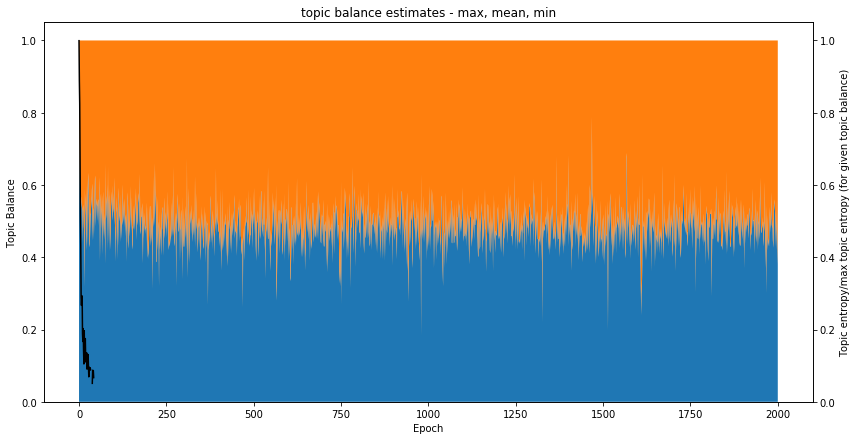

In [27]:
epoch = np.arange(len(tlm.logs['topic_entropy']))

fig, ax_mean = plt.subplots()
ax_mean.stackplot(epoch, np.array(tlm.logs['topic_fraction']).T)
ax_mean.set_xlabel('Epoch')
ax_mean.set_ylabel('Topic Balance')

ax_ent = ax_mean.twinx()
topic_entropy = [e[0] for e in tlm.logs['topic_entropy']]
max_topic_entropy = [(-p*np.log(p)).sum() for p in tlm.logs['topic_fraction']]
frac_topic_entropy = [e/m for e,m in zip(topic_entropy, max_topic_entropy)]
ax_ent.plot(epoch, frac_topic_entropy, color='k')
ax_ent.set_ylabel('Topic entropy/max topic entropy (for given topic balance)')
ax_ent.set_ylim(0,1.05)

fig.set_size_inches(12,6)
fig.tight_layout()
plt.title('topic balance estimates - max, mean, min')

plt.show()

In [28]:
len(tlm.logs['topic_entropy'])

2001

In [32]:
ex.sample(20).sort_values('epoch')

,example,topic_num,epoch
1,fcj<zqmmn,0,0
18,*n srats it ip on himm tretltslt honcan there caif white houveed wilcisitor whoallabling gomeding bi,1,100
19,* * mpair swothan the rasse the rpofe lamt ceam hinctied fils* *he dive the cromed path yours pandse,1,100
10,**he mere and rat nhe elleensins presong mith af*dand the ftraclend bace sith carice the yaralde* ga,0,100
11,*re roung eld the waong die*nnswin*** ind aare* tre thy scalp* hus the cand ent whead soritisud flph,0,100
37,* soul *nntrec the *lvusal stregurouseranced** marolsed at the geart** *ou the peen*tored he voll* *,1,300
48,* ulfserting sprades* *he saidly* *nd * dipte* on * alre the rifs sincert condect at caes quie* *on,1,400
52,** mear of man* bolres** bettey and the daney* ar know** wo sue woof ap up of bmasn* too giex cre wa,0,500
51,* *eroub wor throuessely a cot man** and bowan and to at stint thiting ther wond to dick sork ofll*s,0,500
73,*fter* * dreaen* *he korlald *op in and his our clould bead* *mingul* and theres* *hy the deson the,0,700
